In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
dirname = "sotsuken/"
os.makedirs(dirname, exist_ok=True)
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import scipy.linalg as la

import quantecon as qe
import numpy.linalg as LA

# パラメータセット

In [2]:
# ずっと使ってきたやつ
set_parameter = 3

# ch10
# set_parameter = 2

In [3]:
# 効用関数の設定
# LQR_util = 2で効用をマイナスに設定
# LQR_util = 2ではLQRの重み行列が正定値行列とならず破綻
LQR_util = 1

In [4]:
if set_parameter == 1:
    # Set parameters ずっと使ってきたやつ
    mu_d = 13.0
    rho = 0.05
    gan = 8.0
    c_d = 1.0
    beta_std = 0.95
    R_kinri = 1 / beta_std
    ponji = 1e-9
elif set_parameter == 2:
    # Set parameters in ch10
    mu_d = 13.594
    rho = 0.241
    gan = 500.0
    c_d = 0.2
    beta_std = 0.997
    R_kinri = 1 / beta_std
    ponji = 1e-9
elif set_parameter == 3:
    # 自由に変えていいよ
    mu_d = 13.
    rho = 0.05
    gan = 15.
    c_d = 1.0
    # beta_std = 0.9494764430324878
    beta_std = 0.95
    R_kinri = 1 / beta_std
    ponji = 1e-9

In [5]:
sig_arr = [-1e-9, -1e-1]
d_first = 0.0
k_first = 0.0

In [6]:
# uncertaintyあり、なし全ての期間を決定
iter_t = 1500
iter_uti= iter_t

In [7]:
np.random.seed(7)
eps = np.random.randn(iter_t)

In [8]:
ovr = 120
tapple_y = 20
y_lim = (-ovr, ovr)

# w\o mis 

## in Matlab module

In [9]:
# おまじない
%load_ext autoreload
%autoreload 2

In [10]:
# olrprobust_3はリカッチのif文を削除した
# olrprobust_2との相違点は上記があるか、ないか
from olrprobust_3_using import olrp, olrprobust, doubleo

# olrprobust_2はリカッチのif文有〼
# matlabを極力そのまま移し替えた。
# from olrprobust_2_using import olrp, olrprobust, doubleo

# olrprobust_1はgithubから
# from olrprobust_1_using import olrp,olrprobust,doubleo

In [11]:
# y=[1 d k]のやつ
QLQ_mat = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ponji]])
ALQ_mat = np.array(
    [[1.0, 0.0, 0.0], [(1.0 - rho) * mu_d, rho, 0.0], [-gan, 1.0, R_kinri]]
)
# u=\gamma - c_tにしたため符号を反転した
BLQ_mat = np.array([[0.0], [0.0], [1.0]])
CLQ_mat = np.array([[0.0], [c_d], [0.0]])
RLQ_mat = np.array([[1]])

if LQR_util == 2:
    RLQ_mat = -RLQ_mat
    QLQ_mat = -QLQ_mat
F_nomis_mat, K_nomis_mat, P_nomis_mat, Pt_nomis_mat = olrprobust(
    beta_std, ALQ_mat, BLQ_mat, CLQ_mat, QLQ_mat, RLQ_mat, sig_arr[0]
)
print(f"F = {F_nomis_mat[0]}")

print(P_nomis_mat)
print(np.linalg.eigvals(P_nomis_mat))

F = [-2.68241495  0.05249346  0.0526316 ]
[[ 1.43906976e+02 -2.81618368e+00 -2.82359469e+00]
 [-2.81618368e+00  5.51112406e-02  5.52562703e-02]
 [-2.82359469e+00  5.52562703e-02  5.54016826e-02]]
[1.44017489e+02 2.15302857e-08 4.86197021e-10]


In [12]:
y_nomis_mat = np.array([[1.0, d_first, k_first]])
ABF_nomis_mat = ALQ_mat - BLQ_mat @ F_nomis_mat
for i in range(iter_t):
    y_nomis_mat = np.insert(
        y_nomis_mat, 0, ABF_nomis_mat @ y_nomis_mat[0].T + CLQ_mat.T * eps[i], axis=0
    )

In [13]:
# 0-iter_tまでのiter_t+1の長さになっている。
y_nomis_mat = y_nomis_mat[::-1]
k_nomis_mat = y_nomis_mat[:, 2]
d_nomis_mat = y_nomis_mat[:, 1]

In [14]:
print(f"y.shape = {y_nomis_mat.shape}")

y.shape = (1501, 3)


In [15]:
c_nomis_mat = np.zeros(iter_t + 1)
for i in range(iter_t + 1):
    c_nomis_mat[i] = F_nomis_mat @ y_nomis_mat[i] + gan
print(f"c.shape = {c_nomis_mat.shape}")

c.shape = (1501,)


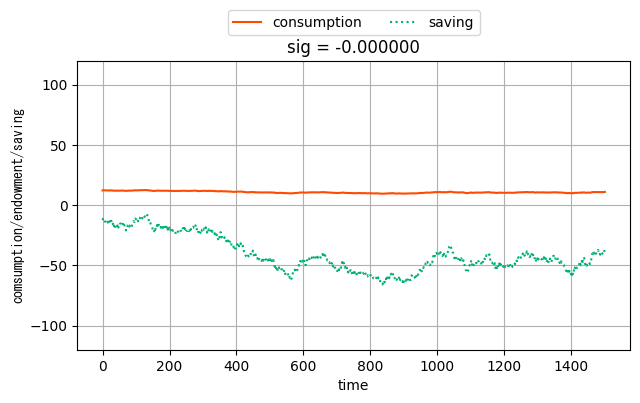

In [16]:

plt.figure(figsize=[6.5, 4.2])
plt.title("sig = %f" % (sig_arr[0]))
plt.ylim(y_lim)
colorlist = ["#FF4B00", "#005AFF", "#03AF7A"]
# Plot consumption
plt.plot(
    np.array(range(iter_t+1)),
    c_nomis_mat[:iter_t+1],
    linestyle="-",
    label="consumption",
    color=colorlist[0],
)

# Plot endowment
#plt.plot(
#    np.array(range(iter_t)),
#    d_nomis_mat[:iter_t],
#    linestyle="--",
#    label="endowment",
#    color=colorlist[1],
#)

# Plot saving
plt.plot(
    np.array(range(iter_t)),
    k_nomis_mat[1:iter_t+1],
    linestyle=":",
    label="saving",
    color=colorlist[2],
)

# Legend with specified arguments
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, prop={"size": 10})
plt.xlabel("time", fontsize=10)
plt.ylabel("comsumption/endowment/saving", fontname="MS Gothic", fontsize=10)
plt.grid()
plt.tight_layout()
plt.savefig("%sch10_1.png" % dirname)

## in Quant

In [17]:
A = np.array([[1.0, 0.0], [(1.0 - rho) * mu_d, rho]])
C = np.array([[0.0], [c_d]])

# ここでは使わない
G = np.array([[0.0, 1.0]])
G_1 = np.array([[1.0, 0.0]])
A12 = np.zeros((2, 1))
ALQ_l = np.hstack([A, A12])
ALQ_r = np.array([[-gan, 1.0, R_kinri]])
ALQ_quant = np.vstack([ALQ_l, ALQ_r])
RLQ_quant = np.array(
    [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        [0.0, 0.0, ponji],
    ]
)
QLQ_quant = np.array([1.0])
BLQ_quant = np.array([0.0, 0.0, 1.0]).reshape(3, 1)
CLQ_quant = np.array([0.0, c_d, 0.0]).reshape(3, 1)
beta_LQ = beta_std

In [18]:
lqpi = qe.LQ(QLQ_quant, RLQ_quant, ALQ_quant, BLQ_quant, C=CLQ_quant, beta=beta_LQ)
P_nomis_quant, F_nomis_quant, d_nomis_quant = lqpi.stationary_values()
print(P_nomis_quant)
print(P_nomis_mat)
print(np.linalg.eigvals(P_nomis_quant))

[[ 1.43906975e+02 -2.81618365e+00 -2.82359466e+00]
 [-2.81618365e+00  5.51112401e-02  5.52562698e-02]
 [-2.82359466e+00  5.52562698e-02  5.54016820e-02]]
[[ 1.43906976e+02 -2.81618368e+00 -2.82359469e+00]
 [-2.81618368e+00  5.51112406e-02  5.52562703e-02]
 [-2.82359469e+00  5.52562703e-02  5.54016826e-02]]
[1.44017488e+02 2.15318885e-08 4.86198070e-10]


In [19]:
print(f"P_nomis_quant=\n{P_nomis_quant}")
print(f"P_nomis_mat=\n{P_nomis_mat}")

P_nomis_quant=
[[ 1.43906975e+02 -2.81618365e+00 -2.82359466e+00]
 [-2.81618365e+00  5.51112401e-02  5.52562698e-02]
 [-2.82359466e+00  5.52562698e-02  5.54016820e-02]]
P_nomis_mat=
[[ 1.43906976e+02 -2.81618368e+00 -2.82359469e+00]
 [-2.81618368e+00  5.51112406e-02  5.52562703e-02]
 [-2.82359469e+00  5.52562703e-02  5.54016826e-02]]


In [20]:
print(f"eig P_nomis_quant=\n{np.linalg.eigvals(P_nomis_quant)}")
print(f"eig P_nomis_mat=\n{np.linalg.eigvals(P_nomis_mat)}")

eig P_nomis_quant=
[1.44017488e+02 2.15318885e-08 4.86198070e-10]
eig P_nomis_mat=
[1.44017489e+02 2.15302857e-08 4.86197021e-10]


## compare both optimal regulator

In [21]:
print(f"F in matlab = \n {F_nomis_mat}")
print(f"F in Quant = \n {F_nomis_quant}")

F in matlab = 
 [[-2.68241495  0.05249346  0.0526316 ]]
F in Quant = 
 [[-2.68241493  0.05249346  0.0526316 ]]


# w\ mis 

## in Matlab module

### uncertainty included の貯蓄プロット

In [22]:
F_mis_mat, K_mis_mat, P_mis_mat, Pt_mis_mat = olrprobust(
    beta_std, ALQ_mat, BLQ_mat, CLQ_mat, QLQ_mat, RLQ_mat, sig_arr[1]
)
print(f"F = {F_mis_mat[0]}")

F = [-2.99614524  0.05863299  0.05878729]


In [23]:
stab=ALQ_quant-BLQ_quant@F_mis_mat
LA.eig(stab)


(array([0.99384429, 0.05      , 1.        ]),
 array([[ 0.        ,  0.        ,  0.0248914 ],
        [ 0.        ,  0.70803535,  0.32358823],
        [ 1.        , -0.70617699,  0.94587054]]))

In [24]:
y_mis_mat = np.array([[1.0, d_first, k_first]])
ABF_mis_mat = ALQ_mat - BLQ_mat @ F_mis_mat
for i in range(iter_t):
    y_mis_mat = np.insert(
        y_mis_mat, 0, ABF_mis_mat @ y_mis_mat[0].T + CLQ_mat.T * eps[i], axis=0
    )

In [25]:
y_mis_mat = y_mis_mat[::-1]
k_mis_mat = y_mis_mat[:, 2]
d_mis_mat = y_mis_mat[:, 1]

In [26]:
c_mis_mat = np.zeros(iter_t + 1)
for i in range(iter_t+1):
    c_mis_mat[i] = F_mis_mat @ y_mis_mat[i] + gan   
print(f"F= {F_mis_mat}")

F= [[-2.99614524  0.05863299  0.05878729]]


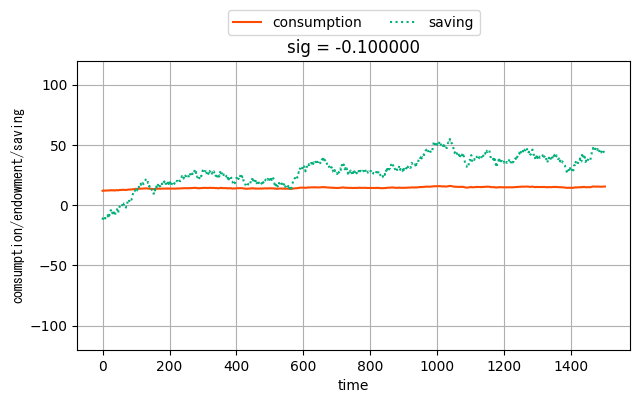

In [27]:
plt.figure(figsize=[6.5, 4.2])
plt.title("sig = %f" % (sig_arr[1]))
plt.ylim(y_lim)
colorlist = ["#FF4B00", "#005AFF", "#03AF7A"]
# Plot consumption
plt.plot(
    np.array(range(iter_t+1)),
    c_mis_mat[:iter_t+1],
    linestyle="-",
    label="consumption",
    color=colorlist[0],
)

# Plot endowment
#plt.plot(
#    np.array(range(iter_t)),
#    d_mis_mat[:iter_t],
#    linestyle="--",
#    label="endowment",
#    color=colorlist[1],
#)

# Plot saving
plt.plot(
    np.array(range(iter_t )),
    k_mis_mat[1:iter_t+1],
    linestyle=":",
    label="saving",
    color=colorlist[2],
)

# Legend with specified arguments
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, prop={"size": 10})
plt.xlabel("time", fontsize=10)
plt.ylabel("comsumption/endowment/saving", fontname="MS Gothic", fontsize=10)
plt.grid()
plt.tight_layout()
plt.savefig("%sch10_2.png" % dirname)

## in Qunat

In [28]:
theta_LQ = -1 / sig_arr[1]

In [29]:
rblq_mis = qe.RBLQ(
    QLQ_quant,
    RLQ_quant,
    ALQ_quant,
    BLQ_quant,
    C=CLQ_quant,
    beta=beta_LQ,
    theta=theta_LQ,
)
(
    F_mis_quant,
    P_mis_quant,
    K_mis_quant,
) = rblq_mis.robust_rule()  # Compute value function and decision rule

In [30]:
print(f"-F in Quant w\ mis= \n {-F_mis_quant}")
print(f"-F in sargent w\ mis = \n {-F_mis_mat}")

-F in Quant w\ mis= 
 [[ 2.99614522 -0.05863299 -0.05878729]]
-F in sargent w\ mis = 
 [[ 2.99614524 -0.05863299 -0.05878729]]


In [31]:
un=A-B@F_mis_mat

NameError: name 'B' is not defined

## 色々比べてみる

### utility

In [ ]:
# i期までの累積効用
util_nomis = np.zeros(iter_t + 1)
util_mis = np.zeros(iter_t + 1)


util_nomis_fun = np.zeros(iter_t + 1)
util_mis_fun = np.zeros(iter_t + 1)
for i in range(iter_uti + 1):  # range(stop): 0 ≦ i < stop
    if i == 0:
        util_nomis[i] = -((c_nomis_mat[i] - gan) ** 2) * beta_std**i
        util_mis[i] = -((c_mis_mat[i] - gan) ** 2) * beta_std**i
    else:
        util_nomis[i] = (
            util_nomis[i - 1] - ((c_nomis_mat[i] - gan) ** 2) * beta_std**i
        )
        util_mis[i] = util_mis[i - 1] - ((c_mis_mat[i] - gan) ** 2) * beta_std**i

    util_nomis_fun[i] = -((c_nomis_mat[i] - gan) ** 2)
    util_mis_fun[i] = -((c_mis_mat[i] - gan) ** 2)
# print(f"util_nomis.shape = {util_nomis.shape}")
# print(f"util_mis.shape = {util_mis.shape}")
print(f"nomis util = {util_nomis[iter_uti-1]}")
print(f"mis util = {util_mis[iter_uti-1]}")

nomis util = -147.5711894328969
mis util = -148.37062664298642


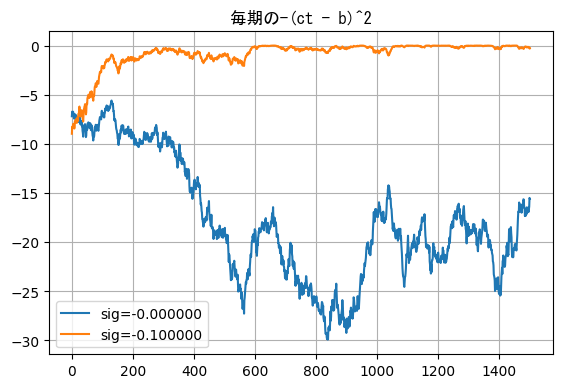

In [ ]:
plt.figure(figsize=[6.5, 4.2])
plt.title("毎期の-(ct - b)^2",fontname="MS Gothic")

# Plot consumption
plt.plot(
    np.array(range(iter_uti+1)),
    util_nomis_fun[:iter_uti+1],
    linestyle="-",
    label="sig=%f" % sig_arr[0],
)

plt.plot(
    np.array(range(iter_uti+1)),
    util_mis_fun[:iter_uti+1],
    linestyle="-",
    label="sig=%f" % sig_arr[1],
)


# Legend with specified arguments
plt.legend()
plt.grid()
plt.savefig("%sch10_util_fun.png" % dirname)

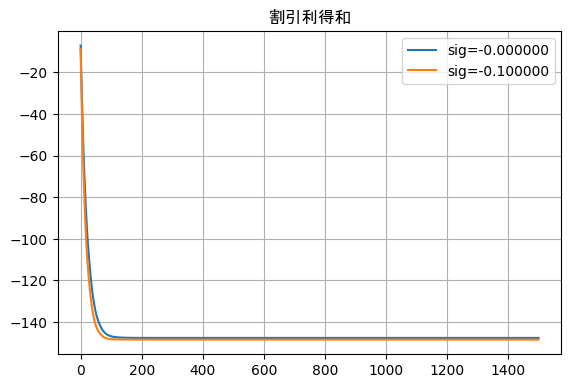

In [ ]:
plt.figure(figsize=[6.5, 4.2])
plt.title("割引利得和",fontname="MS Gothic")

# Plot consumption
plt.plot(
    np.array(range(iter_uti+1)),
    util_nomis[:iter_uti+1],
    linestyle="-",
    label="sig=%f" % sig_arr[0],
)

plt.plot(
    np.array(range(iter_uti+1)),
    util_mis[:iter_uti+1],
    linestyle="-",
    label="sig=%f" % sig_arr[1],
)


# Legend with specified arguments
plt.legend()
plt.grid()
plt.savefig("%sch10_util_fun.png" % dirname)

### mean of consumption

In [ ]:
print(f"ganmma = {gan}")
print(f"mean of consumption w\o mis = {np.mean(c_nomis_mat)}")
print(f"mean of consumption w\ mis  = {np.mean(c_mis_mat)}")

ganmma = 15.0
mean of consumption w\o mis = 10.839076264093208
mean of consumption w\ mis  = 14.464954438881588


#### consumption

In [ ]:
#print(f"consumption w\o mis = {c_nomis_mat}")
#print(f"consumption w\ mis  = {c_mis_mat}")

#### saving

In [ ]:
# savingの
#print(f"saving w\o mis = {k_nomis_mat}")
#print(f"saving w\ mis  = {k_mis_mat}")

### uncertaintyありなしの消費

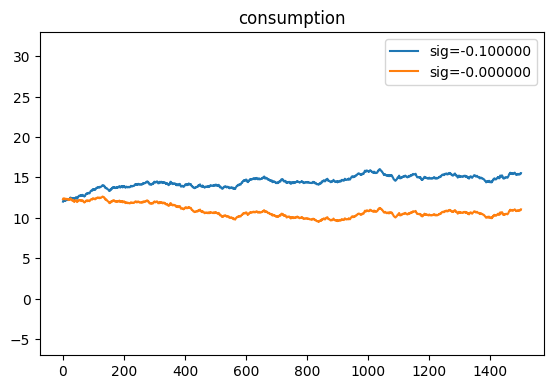

In [ ]:
plt.figure(figsize=[6.5, 4.2])
plt.title("consumption")
plt.ylim((mu_d - tapple_y, mu_d + tapple_y))

# Plot consumption
plt.plot(
    np.array(range(iter_t+1)),
    c_mis_mat[:iter_t+1],
    linestyle="-",
    label="sig=%f" % sig_arr[1],
)

plt.plot(
    np.array(range(iter_t+1)),
    c_nomis_mat[:iter_t+1],
    linestyle="-",
    label="sig=%f" % sig_arr[0],
)


# Legend with specified arguments
plt.legend()
plt.savefig("%sch10_combine.png" % dirname)

### dt - ct = kt - R*kt-1の確認

In [ ]:
k_nomis_sum = np.zeros(iter_t+1)
k_mis_sum = np.zeros(iter_t+1)
#print(f"k_mis_sum.shape = {k_mis_sum.shape}")
for i in range(iter_t):
    k_nomis_sum[i] = k_nomis_mat[i + 1] - R_kinri * k_nomis_mat[i]
    k_mis_sum[i] = k_mis_mat[i + 1] - R_kinri * k_mis_mat[i]

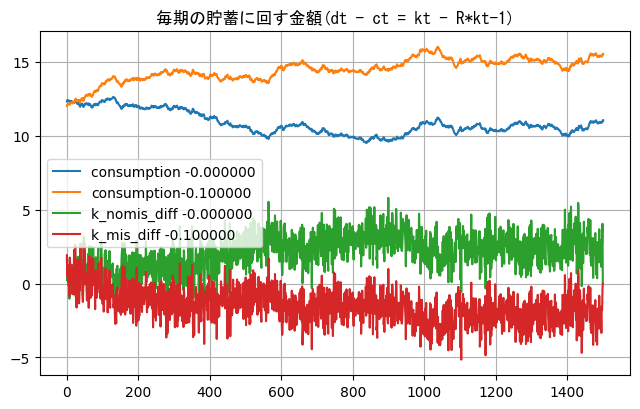

In [ ]:
plt.figure(figsize=[6.5, 4.2])
plt.title("毎期の貯蓄に回す金額(dt - ct = kt - R*kt-1)",fontname="MS Gothic")
#plt.ylim(y_lim)
colorlist = ["#FF4B00", "#005AFF", "#03AF7A"]
# Plot consumption
plt.plot(
    np.array(range(iter_t+1)),
    c_nomis_mat[:iter_t+1],
    linestyle="-",
    label="consumption %f" % sig_arr[0],
)

plt.plot(
    np.array(range(iter_t+1)),
    c_mis_mat[:iter_t+1],
    linestyle="-",
    label="consumption%f" % sig_arr[1],
)

plt.plot(
    np.array(range(iter_t)),
    k_nomis_sum[1:iter_t+1],
    linestyle="-",
    label="k_nomis_diff %f" % sig_arr[0],
)
plt.plot(
    np.array(range(iter_t)),
    k_mis_sum[1:iter_t+1],
    linestyle="-",
    label="k_mis_diff %f" % sig_arr[1],
)





# Plot saving

# Legend with specified arguments
plt.legend()
plt.grid()
plt.tight_layout()

# plt.axhline(y=gan, xmin=0.0, xmax=iter_t, color="r")

plt.savefig("%sch10_sa.png" % dirname)

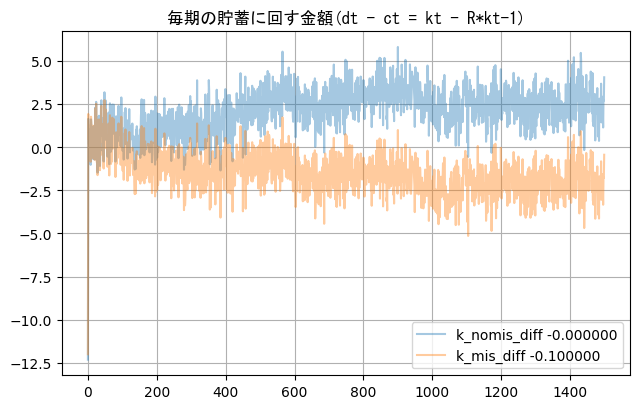

In [ ]:
plt.figure(figsize=[6.5, 4.2])
plt.title("毎期の貯蓄に回す金額(dt - ct = kt - R*kt-1)",fontname="MS Gothic")
# plt.ylim(y_lim)
colorlist = ["#FF4B00", "#005AFF", "#03AF7A"]
# Plot consumption
plt.plot(
    np.array(range(iter_t)),
    k_nomis_sum[:iter_t],
    alpha=0.4,
    linestyle="-",
    label="k_nomis_diff %f" % sig_arr[0],
)
plt.plot(
    np.array(range(iter_t)),
    k_mis_sum[:iter_t],
    alpha=0.4,
    linestyle="-",
    label="k_mis_diff %f" % sig_arr[1],
)

# Plot saving

# Legend with specified arguments
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("%sch10_sa_only_saving.png" % dirname)

### 貯蓄を一枚の図に

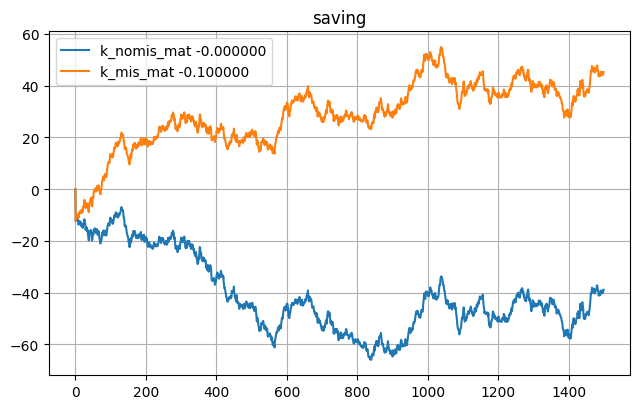

In [ ]:
plt.figure(figsize=[6.5, 4.2])
# plt.ylim(y_lim)
plt.title("saving")
colorlist = ["#FF4B00", "#005AFF", "#03AF7A"]

# Plot consumption
plt.plot(
    np.array(range(iter_t)),
    k_nomis_mat[:iter_t],
    linestyle="-",
    label="k_nomis_mat %f" % sig_arr[0],
)
plt.plot(
    np.array(range(iter_t)),
    k_mis_mat[:iter_t],
    linestyle="-",
    label="k_mis_mat %f" % sig_arr[1],
)
# Plot saving

# Legend with specified arguments
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("%sch10_k_gather.png" % dirname)

### 図を並べる

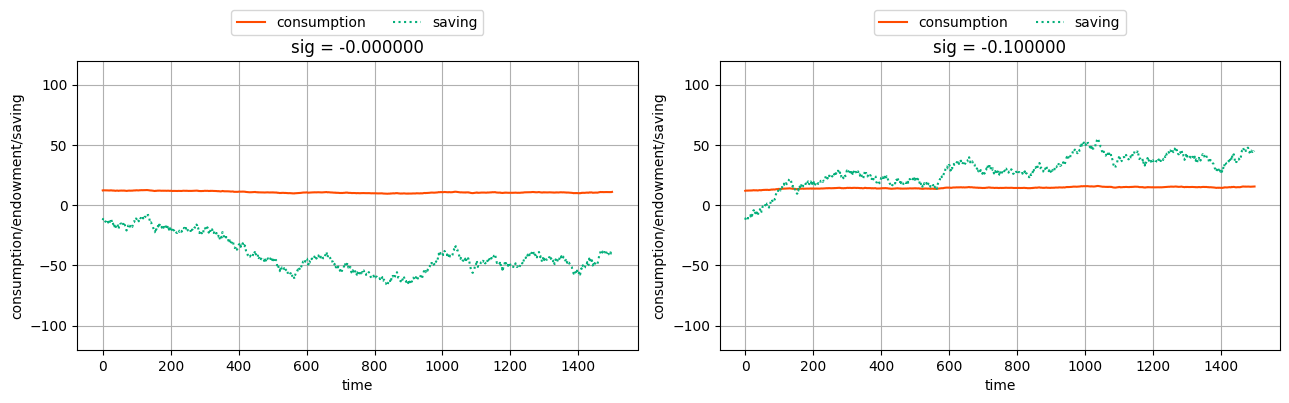

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[13, 4.2])

# Plot for the left side
axes[1].set_title(f"sig = {sig_arr[1]:.6f}")
axes[1].set_ylim(y_lim)
axes[1].plot(
    np.array(range(iter_t)),
    c_mis_mat[:iter_t],
    linestyle="-",
    label="consumption",
    color=colorlist[0],
)
""" axes[1].plot(
    np.array(range(iter_t)),
    d_mis_mat[:iter_t],
    linestyle="--",
    label="endowment",
    color=colorlist[1],
) """
axes[1].plot(
    np.array(range(iter_t - 1)),
    k_mis_mat[1:iter_t],
    linestyle=":",
    label="saving",
    color=colorlist[2],
)
axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, prop={"size": 10})
axes[1].set_xlabel("time", fontsize=10)
axes[1].set_ylabel("consumption/endowment/saving", fontsize=10)
axes[1].grid()

# Plot for the right side
axes[0].set_title(f"sig = {sig_arr[0]:.6f}")
axes[0].set_ylim(y_lim)
axes[0].plot(
    np.array(range(iter_t)),
    c_nomis_mat[:iter_t],
    linestyle="-",
    label="consumption",
    color=colorlist[0],
)
""" axes[0].plot(
    np.array(range(iter_t)),
    d_nomis_mat[:iter_t],
    linestyle="--",
    label="endowment",
    color=colorlist[1],
) """
axes[0].plot(
    np.array(range(iter_t - 1)),
    k_nomis_mat[1:iter_t],
    linestyle=":",
    label="saving",
    color=colorlist[2],
)
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, prop={"size": 10})
axes[0].set_xlabel("time", fontsize=10)
axes[0].set_ylabel("consumption/endowment/saving", fontsize=10)
axes[0].grid()

# Adjust layout
plt.tight_layout()

# Save the combined plot
plt.savefig("%scombined_ch10.png" % dirname)

# Display the combined plot
plt.show()

### 前半の消費の比較

In [ ]:
c_diff = np.zeros(iter_t)
for i in range(iter_t):
    c_diff[i] = c_nomis_mat[i] - c_mis_mat[i]
    print(f"c_mis = {c_mis_mat[i]}")
    print(f"c_nomis = {c_nomis_mat[i]}")
    if c_diff[i] < 0:
        print(f"i = {i}")
        print(f"c_diff[i] = {c_diff[i]}")

c_mis = 12.0038549843221
c_nomis = 12.317585280885329
c_mis = 12.121418885070886
c_nomis = 12.406326789519614
c_mis = 12.111819253179853
c_nomis = 12.381868135747906
c_mis = 12.131522351667272
c_nomis = 12.383590980073947
c_mis = 12.173073712086182
c_nomis = 12.404982912198188
c_mis = 12.144218498938331
c_nomis = 12.363569630558915
c_mis = 12.161918924457826
c_nomis = 12.363678060665514
c_mis = 12.179337074931164
c_nomis = 12.363631322331669
c_mis = 12.093815504360135
c_nomis = 12.271519810469613
c_mis = 12.17137340088048
c_nomis = 12.32494017980851
c_mis = 12.223994572884902
c_nomis = 12.356462412988332
c_mis = 12.204412049341716
c_nomis = 12.323631496519695
c_mis = 12.211562446249939
c_nomis = 12.314626339473476
c_mis = 12.258354417930628
c_nomis = 12.341151242340466
c_mis = 12.259907042924148
c_nomis = 12.327431746452877
c_mis = 12.262541113929688
c_nomis = 12.314689013651906
c_mis = 12.194184203766921
c_nomis = 12.238403375642754
c_mis = 12.243972638561113
c_nomis = 12.267515204430

### 結果がおかしいので振り分けを確認してみる。

#### without uncertainty

In [ ]:
sum_list = []
for i in range(iter_t):
    total = (
        c_nomis_mat[i] + k_nomis_mat[i + 1] - R_kinri * k_nomis_mat[i] - d_nomis_mat[i]
    )
    # print(type(sum))
    sum_list.append(total)
    print(f"total =  {total}")
    # print(f"eps =  {eps[i]}")

# print(f"mean =  {np.mean(sum_list)}")
# print(f"std =  {np.std(sum_list)}")

total =  0.0
total =  0.0
total =  -1.7763568394002505e-15
total =  0.0
total =  0.0
total =  0.0
total =  -1.7763568394002505e-15
total =  0.0
total =  -1.7763568394002505e-15
total =  1.7763568394002505e-15
total =  0.0
total =  -1.7763568394002505e-15
total =  0.0
total =  -1.7763568394002505e-15
total =  0.0
total =  1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  0.0
total =  0.0
total =  0.0
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  0.0
total =  0.0
total =  -1.7763568394002505e-15
total =  0.0
total =  0.0
total =  -1.7763568394002505e-15
total =  1.7763568394002505e-15
total =  -3.552713678800501e-15
total =  -1.7763568394002505e-15
total =  0.0
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  0.0
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  1.7763568394002505e-15
total =  0.0
total =  0.0
total =  0.0
total =  0.0
total =  1.7763568394002505e-15
total =  -1.776356839400250

#### with uncertainty

In [ ]:
sum_list = []
for i in range(iter_t):
    total = c_mis_mat[i] + k_mis_mat[i + 1] - R_kinri * k_mis_mat[i] - d_mis_mat[i]
    # print(type(sum))
    sum_list.append(total)
    print(f"total =  {total}")
    # print(f"eps =  {eps[i]}")

# print(f"mean =  {np.mean(sum_list)}")
# print(f"std =  {np.std(sum_list)}")

total =  0.0
total =  0.0
total =  0.0
total =  -1.7763568394002505e-15
total =  0.0
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  0.0
total =  0.0
total =  -1.7763568394002505e-15
total =  0.0
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  0.0
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  0.0
total =  0.0
total =  0.0
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  0.0
total =  0.0
total =  -1.7763568394002505e-15
total =  -1.7763568394002505e-15
total =  -3.552713678800501e-15
total =  -1.7763568394002505e-15
total =  -3.552713678800501e-15
total =  -1.7763568394002505e-15
total =  0.0
total =  -1.7763568394002505e-15
total =  0.0
total =  0.0
total =  0.0
total =  -1.77635683940

# Observational Equivalence

sig=0の時のFを用いて\betaを調整。

In [ ]:
print(f"beta= {beta_std}")
print(f"optimal decision = {-F_nomis_mat[0]}\n")

nu = -F_nomis_mat @ CLQ_mat
alfa2 = nu.T @ nu
# print(alfa2)
beta_hat = 1 / R_kinri + sig_arr[1] * alfa2 / (R_kinri - 1)
print(f"LQR_util = {LQR_util}")
print(f"QLQ_mat = {QLQ_mat}\n")
print(f"beta hat = {beta_hat[0][0]}")
print(f"sig_arr = {sig_arr[1]}")



F_obs, K2, P2, Pt2 = olrprobust(
    beta_hat, ALQ_mat, BLQ_mat, CLQ_mat, QLQ_mat, RLQ_mat, sig_arr[1]
)
print(f"optimal decision = {-F_obs[0]}\n")

beta= 0.95
optimal decision = [ 2.68241472 -0.05249344 -0.05263158]

LQR_util = 1
QLQ_mat = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

beta hat = 0.9447644338824109
sig_arr = -0.1
optimal decision = [ 2.68241471 -0.05249344 -0.05263158]



In [ ]:
beta_hat2=0.9447644303007632
sig_arr2=-1e-1
F_obs, K2, P2, Pt2 = olrprobust(
    beta_hat2, ALQ_mat, BLQ_mat, CLQ_mat, QLQ_mat, RLQ_mat, sig_arr2
)
print(f"optimal decision = {-F_obs[0]}\n")

optimal decision = [ 2.6824145  -0.05249343 -0.05263158]



## 同じプロットが得られるのか確認

In [ ]:
y_mis_mat_obs = np.array([[1.0, d_first, k_first]])
ABF_mis_mat_obs = ALQ_mat - BLQ_mat @ F_obs
for i in range(iter_t):
    y_mis_mat_obs = np.insert(
        y_mis_mat_obs,
        0,
        ABF_mis_mat_obs @ y_mis_mat_obs[0].T + CLQ_mat.T * eps[i],
        axis=0
    )

In [ ]:
y_mis_mat_obs = y_mis_mat_obs[::-1]
k_mis_mat_obs = y_mis_mat_obs[:, 2]
d_mis_mat_obs = y_mis_mat_obs[:, 1]

In [ ]:
c_mis_mat_obs = np.zeros(iter_t + 1)
for i in range(iter_t):
    c_mis_mat_obs[i] = F_obs @ y_mis_mat_obs[i] + gan
#print(c_mis_mat_obs[-2])
print(np.average(c_mis_mat_obs[:-1]),np.std(c_mis_mat_obs[:-1]))
print(np.average(k_mis_mat_obs),np.std(k_mis_mat_obs))

10.838922932995603 0.7782875678619939
-41.03182038316776 14.82061616801337


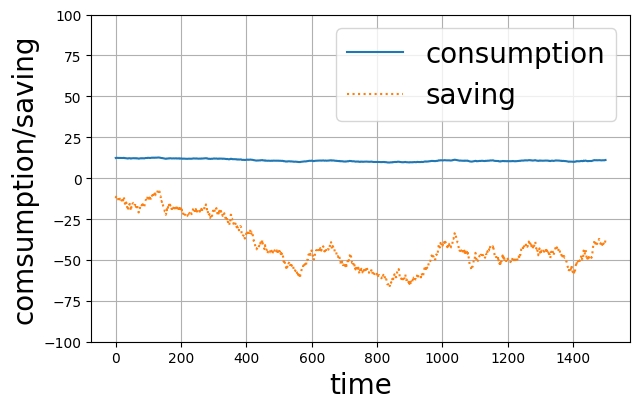

In [ ]:
plt.figure(figsize=[6.5, 4.2])
plt.ylim((-100, 100))
plt.plot(
    np.array(range(iter_t)),
    c_mis_mat_obs[:iter_t],
    linestyle="-",
    label="consumption",
)

# Plot saving
plt.plot(
    np.array(range(iter_t )),
    k_mis_mat_obs[1:iter_t+1],
    linestyle=":",
    label="saving",
)
plt.legend(fontsize=20)
plt.xlabel("time", fontsize=20)
plt.ylabel("comsumption/saving", fontsize=20)
plt.grid()
plt.tight_layout()

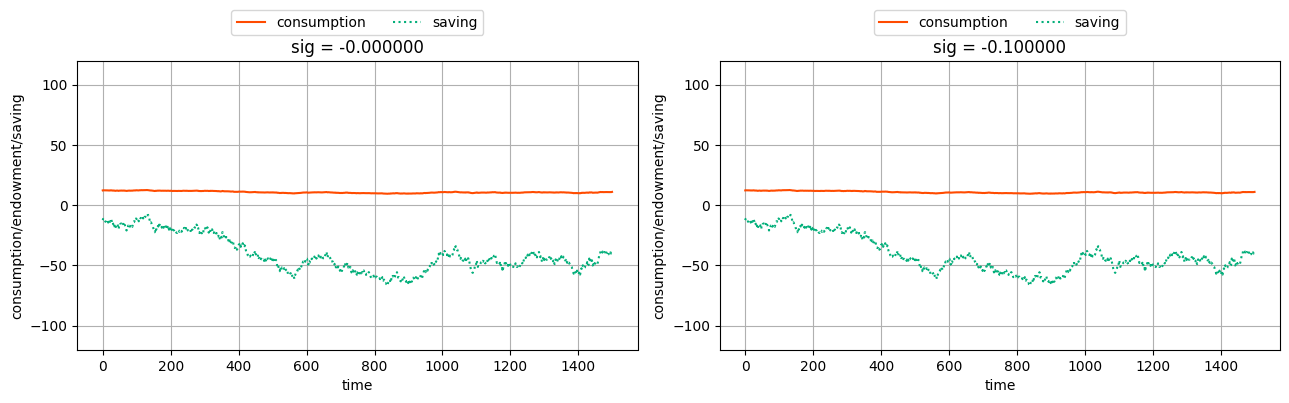

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[13, 4.2])

# Plot for the left side
axes[1].set_title(f"sig = {sig_arr[1]:.6f}")
axes[1].set_ylim(y_lim)
axes[1].plot(
    np.array(range(iter_t)),
    c_mis_mat_obs[:iter_t],
    linestyle="-",
    label="consumption",
    color=colorlist[0],
)
""" axes[1].plot(
    np.array(range(iter_t)),
    d_mis_mat[:iter_t],
    linestyle="--",
    label="endowment",
    color=colorlist[1],
) """
axes[1].plot(
    np.array(range(iter_t - 1)),
    k_mis_mat_obs[1:iter_t],
    linestyle=":",
    label="saving",
    color=colorlist[2],
)
axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, prop={"size": 10})
axes[1].set_xlabel("time", fontsize=10)
axes[1].set_ylabel("consumption/endowment/saving", fontsize=10)
axes[1].grid()

# Plot for the right side
axes[0].set_title(f"sig = {sig_arr[0]:.6f}")
axes[0].set_ylim(y_lim)
axes[0].plot(
    np.array(range(iter_t)),
    c_nomis_mat[:iter_t],
    linestyle="-",
    label="consumption",
    color=colorlist[0],
)
""" axes[0].plot(
    np.array(range(iter_t)),
    d_nomis_mat[:iter_t],
    linestyle="--",
    label="endowment",
    color=colorlist[1],
) """
axes[0].plot(
    np.array(range(iter_t - 1)),
    k_nomis_mat[1:iter_t],
    linestyle=":",
    label="saving",
    color=colorlist[2],
)
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, prop={"size": 10})
axes[0].set_xlabel("time", fontsize=10)
axes[0].set_ylabel("consumption/endowment/saving", fontsize=10)
axes[0].grid()

# Adjust layout
plt.tight_layout()

# Save the combined plot
plt.savefig("%scombined_ch10.png" % dirname)

# Display the combined plot
plt.show()